In [1]:
import os
import json
from pathlib import Path
from statistics import mean
from collections import defaultdict

import torch
import numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
# Helper function to load a JSONL file
def load_jsonl(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        return [json.loads(line.strip()) for line in f]
# Set proxy configuration


# Set visible CUDA device
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("baidu/ERNIE-4.5-21B-A3B-PT", trust_remote_code=True)

# Define input path and read range
dataset_name = "csqa"

if dataset_name == "triviaqa":
    base_path = Path('./cache_data/triviaqa')
    line_range = {"begin": 0, "end": 5000}
    # Load reference dataset
    dataset = load_dataset("trivia_qa", "rc.nocontext")["validation"]
    # Load semantic cluster metadata
    cluster_data = load_jsonl('./cache_data/ernie/triviaqa/semantic_clusters.jsonl')
else:
    base_path = Path('./cache_data/ernie/csqa')
    line_range = {"begin": 0, "end": 3000}
    # Load reference dataset
    dataset = load_dataset("OpenStellarTeam/Chinese-SimpleQA")['train']
    # Load semantic cluster metadata
    cluster_data = load_jsonl('./cache_data/ernie/csqa/semantic_clusters.jsonl')

# Load model outputs from multiple response files
all_data = []
for file_idx in range(1, 8):  # Iterate over 10 response files
    file_name = f'response_{file_idx}.jsonl'
    file_path = base_path / file_name

    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()[line_range['begin']:line_range['end']]
        for line in lines:
            item = json.loads(line.strip())

            # Find the index of token 3407 (used as delimiter), if present
            try:
                end_idx = item["token_ids"][2:].index(23)+2
            except ValueError:
                end_idx = len(item["token_ids"])

            # Append processed item to all_data
            all_data.append({
                'question_id': item['question_id'],
                'answer': item['answer'],
                'logits': item['logits'][:end_idx],      # Logits for generated tokens (up to end token)
                'probs': item['probs'][:end_idx],        # Probabilities for generated tokens
                'token_ids': item['token_ids'][:end_idx] # Token IDs (truncated)
            })

# Group all responses by question ID
question_groups = defaultdict(list)
for item in all_data:
    question_groups[item['question_id']].append(item)

all_logits = [mean(item['logits']) for item in all_data]


/root/miniconda3/envs/qwen/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(all_data[1])

{'question_id': 1, 'answer': '剥取芸香科植物黄皮树树皮，除去粗皮，晒干后得到的中药药材叫**川黄柏**。\n\n川黄柏是芸香科植物黄皮树（Phellodendron chinense Schneid.）的干燥树皮，具有清热燥湿、泻火除蒸、解毒疗疮的功效，常用于治疗湿热泻痢、黄疸尿赤、带下阴痒、热淋涩痛、脚气痿躄、骨蒸劳热、盗汗、遗精、疮疡肿毒、湿疹瘙痒等症。', 'logits': [33.75, 44.375, 36.666664123535156, 52.70833206176758, 63.75, 43.541664123535156, 46.25, 48.33333206176758, 47.291664123535156, 34.791664123535156, 50.83333206176758, 37.5, 39.791664123535156, 47.291664123535156, 55.0, 37.291664123535156, 45.625, 55.416664123535156, 40.625, 42.70833206176758, 47.70833206176758, 41.875, 37.5, 38.95833206176758, 31.25, 36.875, 46.666664123535156, 54.58333206176758, 42.70833206176758], 'probs': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.26082903146743774, 1.0, 1.0, 1.0, 1.0], 'token_ids': [97609, 94512, 98820, 94922, 94287, 8454, 94773, 94781, 95040, 95040, 94781, 93956, 55465, 96127, 94781, 93956, 96603, 94600, 94071, 35416, 14398, 70781, 94954, 386, 95481, 94773, 96975, 

In [3]:
import math
from math import prod
from statistics import mean


def sum_normalize(lst):
    """
    Normalize a list so that its elements sum to 1.
    If the total sum is zero, returns a list of zeros.
    """
    total = sum(lst)
    return [x / total if total != 0 else 0 for x in lst]


def cal_cluster_ce(probs, logits, clusters):
    """
    Calculate cluster-level cross entropy and summed logits.

    Args:
        probs (List[float]): List of probabilities for each item.
        logits (List[float]): List of logits for each item.
        clusters (List[List[int]]): Index clusters over which to aggregate values.

    Returns:
        Tuple:
            - probs_se: Summed normalized probabilities per cluster.
            - logits_se: Negative summed logits per cluster.
    """
    probs_se = []
    logits_se = []

    # Normalize probabilities once
    normalized_probs = sum_normalize(probs)

    for cluster in clusters:
        # Sum normalized probabilities within the cluster
        cluster_prob_sum = sum(normalized_probs[i] for i in cluster)
        probs_se.append(cluster_prob_sum)

        # Sum logits (negated) within the cluster
        cluster_logit_sum = -sum(logits[i] for i in cluster)
        logits_se.append(cluster_logit_sum)

    return probs_se, logits_se


def cal_probs(probs_list):
    """
    Calculate the product of probabilities for each item list.

    Args:
        probs_list (List[List[float]]): A list of token-level probability lists.

    Returns:
        List[float]: Product of probabilities per item.
    """
    return [prod(sublist) for sublist in probs_list]


def fermi_dirac(E, mu, kT):
    """
    Apply the Fermi-Dirac function.

    Args:
        E (float): Energy level (logit value).
        mu (float): Chemical potential.
        kT (float): Thermal energy (default = 1.0).

    Returns:
        float: Fermi-Dirac value.
    """
    return E / (math.exp((E - mu) / kT) + 1)



def cal_boltzmann_logits(logits_list):
    """
    Apply Boltzmann transformation (negated mean of logits).

    Args:
        logits_list (List[List[float]]): List of token-level logits per item.

    Returns:
        List[float]: Transformed logits per item.
    """
    return [-mean(sublist) for sublist in logits_list]


def cal_flow(question_group, clusters, fermi_mu=None):
    """
    Compute cluster-wise flow using probabilities and logits.

    Args:
        question_group (List[Dict]): Group of model responses for a question.
        clusters (List[List[int]]): Cluster indices.
        fermi_mu (float, optional): If provided, applies Fermi-Dirac transformation.

    Returns:
        Tuple[List[float], List[float]]:
            - Cluster-level summed probabilities
            - Cluster-level weighted logits (Fermi-Dirac or Boltzmann)
    """
    probs_list = [item['probs'] for item in question_group]
    logits_list = [item['logits'] for item in question_group]

    # Compute the product of token probabilities per item
    probs = cal_probs(probs_list)

    # Apply appropriate logit transformation
    if fermi_mu is not None:
        logits = cal_fermi_dirac_logits(logits_list, mu=fermi_mu)
    else:
        logits = cal_boltzmann_logits(logits_list)

    # Return cluster-level cross-entropy and logit scores
    return cal_cluster_ce(probs, logits, clusters)



In [4]:
import json
import numpy as np
from math import prod
from statistics import mean
from scipy.stats import spearmanr, pearsonr

# load judgement result
question_cluster_scores = {}
data_list = []

for answer_idx in range(1, 8):
    if dataset_name == 'csqa':
        path = f'./cache_data/ernie/csqa/judgement_{answer_idx}.json'
    elif dataset_name == 'trivia_qa_split':
        path = f'./cache_data/ernie/triviaqa/judgement_{answer_idx}.json'
    with open(path, 'r') as f:
        data = json.load(f)
    data_list.append(data)


===Table 1===

Semantic Energy (Logits)
 AUROC = 80.2
AUPR = 77.5
FPR@95TPR = 65.0
--------------------
Semantic Entropy (Probs)
 AUROC = 77.4
AUPR = 73.2
FPR@95TPR = 70.9


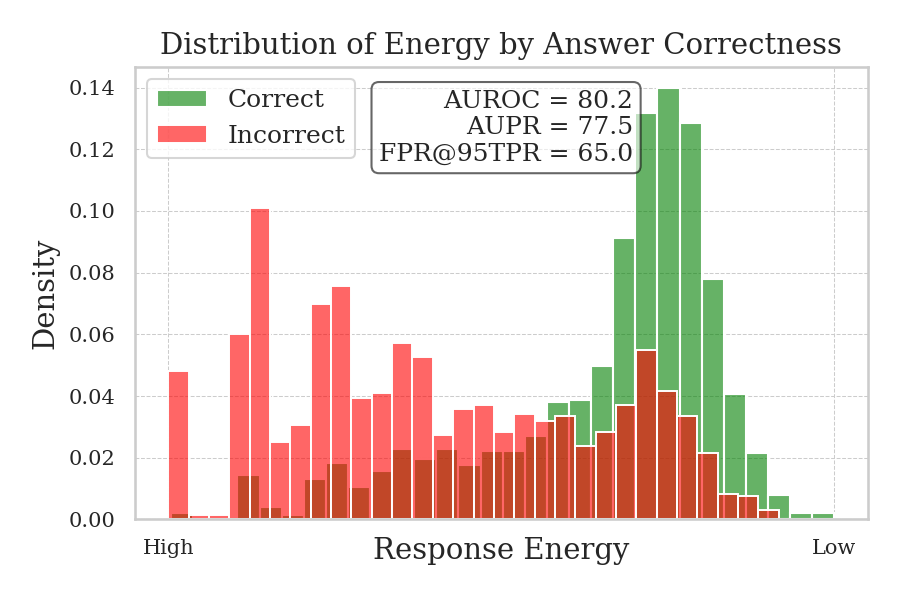

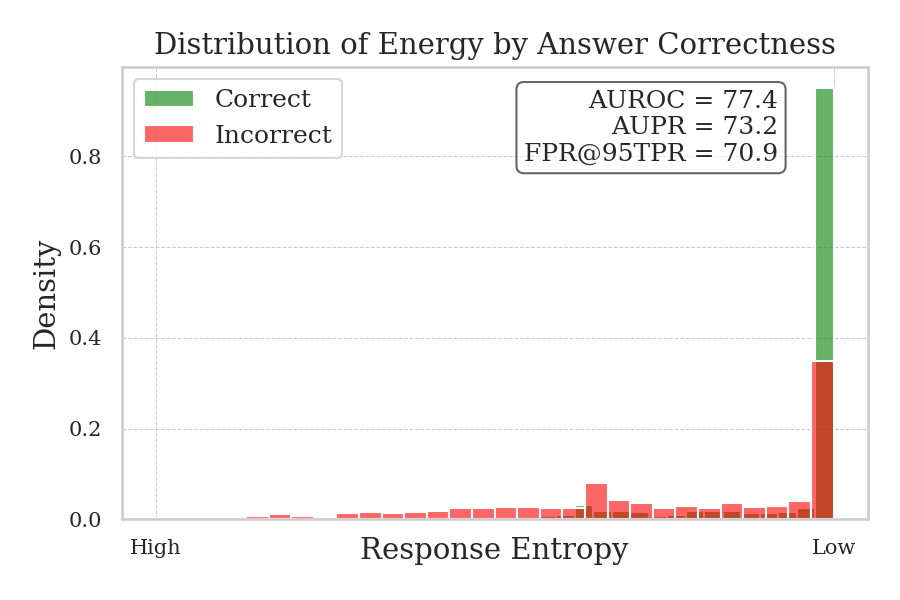

In [5]:
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_fscore_support, roc_curve
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Image
from io import BytesIO
print("===Table 1===\n")

# ========== Seaborn Styling ==========
sns.set(style="whitegrid", font_scale=1.2, rc={
    "font.family": "serif",
    "font.serif": ["DejaVu Serif"],
    "axes.labelsize": 14,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 12
})

def top_k_precision(scores, labels, k=1.0):
    if len(scores) == 0:
        return float('nan')
    sorted_indices = np.argsort(scores)[::-1]
    top_k_count = int(len(scores) * k)
    top_k_indices = sorted_indices[:top_k_count]
    top_k_labels = np.array(labels)[top_k_indices]
    return np.sum(top_k_labels) / len(top_k_labels) if len(top_k_labels) > 0 else float('nan')

def safe_roc_auc_score(y_true, y_score):
    try:
        return roc_auc_score(y_true, y_score)
    except:
        return float('nan')

def safe_average_precision_score(y_true, y_score):
    try:
        return average_precision_score(y_true, y_score)
    except:
        return float('nan')

def compute_metrics(labels, scores):
    auroc = safe_roc_auc_score(labels, scores)
    aupr = safe_average_precision_score(labels, scores)
    try:
        fpr, tpr, thresholds = roc_curve(labels, scores)
        fpr_at_95_tpr = next((fpr[i] for i in range(len(tpr)) if tpr[i] >= 0.95), float('nan'))
    except:
        fpr_at_95_tpr = float('nan')
    precision, recall, f1, _ = precision_recall_fscore_support(labels, [int(s >= 0.5) for s in scores], average='binary', zero_division=0)
    return auroc, aupr, fpr_at_95_tpr, precision, recall, f1


# ========== Sample-Level Energy AUROC (Logits) ==========
sample_scores_logits = []
sample_labels = []

for question_id in range(len(question_groups)):
    clusters = cluster_data[question_id]['clusters']
    score_probs_se, score_logits_se = cal_flow(question_groups[question_id], clusters, fermi_mu=None)

    best_cluster_idx = np.argmax(score_logits_se)
    best_cluster = clusters[best_cluster_idx]
    best_score = score_logits_se[best_cluster_idx]

    if not best_cluster:
        continue

    sample_idx = best_cluster[0]
    answer_idx = sample_idx + 1

    try:
        correct_flag = 1 if next(x for x in data_list[answer_idx - 1] if x["question_idx"] == question_id)["correct"] else 0
    except StopIteration:
        continue

    sample_scores_logits.append(best_score)
    sample_labels.append(correct_flag)

auroc, aupr, fpr95, precision, recall, f1 = compute_metrics(sample_labels, sample_scores_logits)
auroc_text = f"AUROC = {auroc * 100:.1f}\nAUPR = {aupr * 100:.1f}\nFPR@95TPR = {fpr95 * 100:.1f}" if not np.isnan(auroc) else "AUROC N/A"
print("Semantic Energy (Logits)\n", auroc_text)

scaler = MinMaxScaler()
normalized_scores_logits = 30 * scaler.fit_transform(np.array(sample_scores_logits).reshape(-1, 1)).flatten()
correct_logits = [s for s, l in zip(normalized_scores_logits, sample_labels) if l == 1]
incorrect_logits = [s for s, l in zip(normalized_scores_logits, sample_labels) if l == 0]

plt.figure(figsize=(6, 4), dpi=300)
sns.histplot(correct_logits, bins=30, color='green', kde=False, label='Correct', stat="density", alpha=0.6)
sns.histplot(incorrect_logits, bins=30, color='red', kde=False, label='Incorrect', stat="density", alpha=0.6)
plt.xlabel("Response Energy", labelpad=-10)
plt.ylabel("Density")
plt.title("Distribution of Energy by Answer Correctness", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xticks([min(normalized_scores_logits), max(normalized_scores_logits)], ['High', 'Low'])

plt.text(
    0.68, 0.95, auroc_text,
    horizontalalignment='right',
    verticalalignment='top',
    transform=plt.gca().transAxes,
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', alpha=0.6)
)

buf1 = BytesIO()
plt.tight_layout()
plt.savefig(buf1, format='png', dpi=150)
plt.close()

def entropy(p):
    p = np.clip(p, 1e-12, 1.0)  # 防止 log(0)
    return -np.sum(p * np.log(p))

# ========== Sample-Level Energy AUROC (Probs/Entropy) ==========
sample_scores_probs = []
sample_labels = []

for question_id in range(len(question_groups)):
    clusters = cluster_data[question_id]['clusters']
    score_probs_se, score_logits_se = cal_flow(question_groups[question_id], clusters)

    best_cluster_idx = np.argmax(score_probs_se)
    best_cluster = clusters[best_cluster_idx]
    best_score = -entropy(score_probs_se)

    if not best_cluster:
        continue

    sample_idx = best_cluster[0]
    answer_idx = sample_idx + 1

    try:
        correct_flag = 1 if next(x for x in data_list[answer_idx - 1] if x["question_idx"] == question_id)["correct"] else 0
    except StopIteration:
        continue

    sample_scores_probs.append(best_score)
    sample_labels.append(correct_flag)

auroc, aupr, fpr95, precision, recall, f1 = compute_metrics(sample_labels, sample_scores_probs)
auroc_text = f"AUROC = {auroc * 100:.1f}\nAUPR = {aupr * 100:.1f}\nFPR@95TPR = {fpr95 * 100:.1f}" if not np.isnan(auroc) else "AUROC N/A"
print("--" * 10)
print("Semantic Entropy (Probs)\n", auroc_text)

scaler = MinMaxScaler()
normalized_scores_probs = 30 * scaler.fit_transform(np.array(sample_scores_probs).reshape(-1, 1)).flatten()
correct_probs = [s for s, l in zip(normalized_scores_probs, sample_labels) if l == 1]
incorrect_probs = [s for s, l in zip(normalized_scores_probs, sample_labels) if l == 0]

plt.figure(figsize=(6, 4), dpi=300)
sns.histplot(correct_probs, bins=30, color='green', kde=False, label='Correct', stat="density", alpha=0.6)
sns.histplot(incorrect_probs, bins=30, color='red', kde=False, label='Incorrect', stat="density", alpha=0.6)
plt.xlabel("Response Entropy", labelpad=-10)
plt.ylabel("Density")
plt.title("Distribution of Energy by Answer Correctness", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xticks([min(normalized_scores_probs), max(normalized_scores_probs)], ['High', 'Low'])

plt.text(
    0.88, 0.95, auroc_text,
    horizontalalignment='right',
    verticalalignment='top',
    transform=plt.gca().transAxes,
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', alpha=0.6)
)

buf2 = BytesIO()
plt.tight_layout()
plt.savefig(buf2, format='png', dpi=150)
plt.close()

# 显示图像
display(Image(data=buf1.getvalue()), Image(data=buf2.getvalue()))


In [6]:
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_fscore_support, roc_curve
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Image
from io import BytesIO
print("===Table 2===")
# ========== Seaborn Styling ==========
sns.set(style="whitegrid", font_scale=1.2, rc={
    "font.family": "serif",
    "font.serif": ["DejaVu Serif"],
    "axes.labelsize": 14,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 12
})

def top_k_precision(scores, labels, k=1.0):
    if len(scores) == 0:
        return float('nan')
    sorted_indices = np.argsort(scores)[::-1]
    top_k_count = int(len(scores) * k)
    top_k_indices = sorted_indices[:top_k_count]
    top_k_labels = np.array(labels)[top_k_indices]
    return np.sum(top_k_labels) / len(top_k_labels) if len(top_k_labels) > 0 else float('nan')

def safe_roc_auc_score(y_true, y_score):
    try:
        return roc_auc_score(y_true, y_score)
    except:
        return float('nan')

def safe_average_precision_score(y_true, y_score):
    try:
        return average_precision_score(y_true, y_score)
    except:
        return float('nan')

def compute_metrics(labels, scores):
    auroc = safe_roc_auc_score(labels, scores)
    aupr = safe_average_precision_score(labels, scores)
    try:
        fpr, tpr, thresholds = roc_curve(labels, scores)
        fpr_at_95_tpr = next((fpr[i] for i in range(len(tpr)) if tpr[i] >= 0.95), float('nan'))
    except:
        fpr_at_95_tpr = float('nan')
    precision, recall, f1, _ = precision_recall_fscore_support(labels, [int(s >= 0.5) for s in scores], average='binary', zero_division=0)
    return auroc, aupr, fpr_at_95_tpr, precision, recall, f1


# ========== Sample-Level Energy AUROC (Logits) ==========
sample_scores_logits = []
sample_labels = []

for question_id in range(len(question_groups)):
    clusters = cluster_data[question_id]['clusters']
    if len(clusters) != 1:
        continue  # 只统计只有一个 cluster 的问题

    score_probs_se, score_logits_se = cal_flow(question_groups[question_id], clusters, fermi_mu=None)

    best_cluster_idx = np.argmax(score_logits_se)
    best_cluster = clusters[best_cluster_idx]
    best_score = score_logits_se[best_cluster_idx]

    if not best_cluster:
        continue

    sample_idx = best_cluster[0]
    answer_idx = sample_idx + 1

    try:
        correct_flag = 1 if next(x for x in data_list[answer_idx - 1] if x["question_idx"] == question_id)["correct"] else 0
    except StopIteration:
        continue

    sample_scores_logits.append(best_score)
    sample_labels.append(correct_flag)


auroc, aupr, fpr95, precision, recall, f1 = compute_metrics(sample_labels, sample_scores_logits)
auroc_text = f"AUROC = {auroc * 100:.1f}\nAUPR = {aupr * 100:.1f}\nFPR@95TPR = {fpr95 * 100:.1f}" if not np.isnan(auroc) else "AUROC N/A"
print(auroc_text)
# ========== 统计正样本比例 ==========
num_positive = np.sum(sample_labels)
total_samples = len(sample_labels)
positive_ratio = num_positive / total_samples if total_samples > 0 else float('nan')
print(f"正样本比例 = {positive_ratio * 100:.2f}% ({num_positive}/{total_samples})")


===Table 2===
AUROC = 58.9
AUPR = 81.9
FPR@95TPR = 88.4
正样本比例 = 77.03% (1043/1354)
